### Udacity DRL Project2 - Continuous Control: PPO Solution
#### Adapted from:
- Shangtong Zhang: https://github.com/ShangtongZhang/DeepRL
- Jeremi Kaczmarczyk: https://github.com/jknthn 

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
import sys
import random
from collections import namedtuple, deque

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
#from unityagents import UnityEnvironment
from IPython.display import clear_output

from network_model import PPONet
from ppo_agent import PPOAgent

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like:
 [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [5]:
#env_info

In [6]:
#brain

In [7]:
#brain.vector_action_descriptions

In [8]:
#brain.vector_action_space_type

In [9]:
# config file
config = {
    'environment': {
        'state_size':  env_info.vector_observations.shape[1],
        'action_size': brain.vector_action_space_size,
        'number_of_agents': len(env_info.agents)
    },
    'pytorch': {
        'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    },
    'hyperparameters': {
        'discount_rate': 0.99,
        'tau': 0.95,
        'gradient_clip': 5,
        'rollout_length': 2048,
        'optimization_epochs': 10,
        'ppo_clip': 0.2,
        'log_interval': 2048,
        'max_steps': 1e5,
        'mini_batch_number': 32,
        'entropy_coefficent': 0.01,
        'episode_count': 250,
        'hidden_size': 512,
        'adam_learning_rate': 3e-4,
        'adam_epsilon': 1e-5
    }
}

In [10]:
#xp = PPONet(config)

In [11]:
#xp

In [12]:
#xp.forward(states) #.to.device("cuda:0" if torch.cuda.is_available() else "cpu"))

In [13]:
"""
Execute an iteration of:
- reset env
- fetch current state of system
- select action 
- send action to env 
- get next state 
- get reward 
- chech if done 
- update state 
- exit if finished
"""

def step_iteration(env, brain_name, policy, config):
    env_info = env.reset(train_mode=True)[brain_name]                       # reset the environment   
    states = env_info.vector_observations                                   # get current state
    scores = np.zeros(config['environment']['number_of_agents'])            # initialize scores
    while True:                                                             # Loop until done
        actions, _, _, _ = policy(states)                                   # select an action via the policy
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]     # send the action to the env
        next_states = env_info.vector_observations                          # get the next state
        rewards = env_info.rewards                                          # get the reward
        dones = env_info.local_done                                         # see if episode has finished
        scores += env_info.rewards                                          # update the scores with the reward
        states = next_states                                                # update state with next_state
        if np.any(dones):                                                   # exit loop if episode is finished
            break
    
    return np.mean(scores)

In [14]:
def run_ppo_episodes(env, brain_name, policy, config, train):
    if train:
        optimizier = optim.Adam(policy.parameters(), config['hyperparameters']['adam_learning_rate'], 
                        eps=config['hyperparameters']['adam_epsilon'])
        agent = PPOAgent(env, brain_name, policy, optimizier, config)
        all_scores = []
        averages = []
        last_max = 30.0
        
        for i in tqdm.tqdm(range(config['hyperparameters']['episode_count'])):   # do number of episodes
            agent.step()                                                         # perform step function inside PPOAgent
            last_mean_reward = step_iteration(env, brain_name, policy, config)   # step/loop thru an episode until "done"
            last_100_average = np.mean(np.array(all_scores[-100:])) if len(all_scores) > 100 else np.mean(np.array(all_scores))
            all_scores.append(last_mean_reward)
            averages.append(last_100_average)
            if last_100_average > last_max:
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended
                #torch.save(policy.state_dict(), f"models/ppo-max-hiddensize-{config['hyperparameters']['hidden_size']}.pth")
                torch.save(policy.state_dict(), f"BestModel.pth")
                last_max = last_100_average
            clear_output(True)
            print('Episode: {} Total score this episode: {} Last {} average: {}'.format(i + 1, last_mean_reward, min(i + 1, 100), last_100_average))
        return all_scores, averages
    else:
        # step/loop thru an episode until "done"
        score = step_iteration(env, brain_name, policy, config)
        return [score], [score]

### --------------------------------------------------------------------------------------------- 
#### Train the PPO network with Actor-Critic

In [15]:
# TRAIN
new_policy = PPONet(config)
all_scores, average_scores = run_ppo_episodes(env, brain_name, new_policy, config, train=True)

100%|██████████| 250/250 [1:27:32<00:00, 21.61s/it]

Episode: 250 Total score this episode: 38.40699914153665 Last 100 average: 38.0482241495559


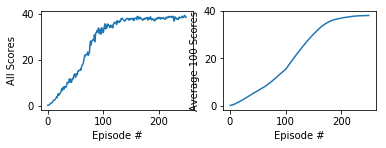

In [16]:
# plot the scores
fig = plt.figure()

ax = fig.add_subplot(221)
plt.plot(np.arange(len(all_scores)), all_scores)
plt.ylabel('All Scores')
plt.xlabel('Episode #')

ax = fig.add_subplot(222)
plt.plot(np.arange(len(average_scores)), average_scores)
plt.ylabel('Average 100 Scores')
plt.xlabel('Episode #')

plt.show()

#### Execute a run

In [ ]:
# INFER
policy = PPONet(config)
#policy.load_state_dict(torch.load('models/ppo-max-hiddensize-512.pth'))
policy.load_state_dict(torch.load('BestModel.pth'))
_, _ = run_ppo_episodes(env, brain_name, policy, config, train=False)

In [ ]:
#optimizier = optim.Adam(policy.parameters(), config['hyperparameters']['adam_learning_rate'], 
#                        eps=config['hyperparameters']['adam_epsilon'])
#agent = PPOAgent(env, brain_name, policy, optimizier, config)

In [ ]:
#play_round(env, brain_name, policy, config)

In [ ]:
actions, _, _, _ = policy(states)
print(actions)

In [ ]:
policy.forward(states)